<a href="https://colab.research.google.com/github/hr1588/NLP/blob/main/nlp_ch4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=4)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 538 (delta 165), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (538/538), 46.22 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.26.0
Using datasets v2.9.0
Using accelerate v0.16.0
Using sentencepiece v0.1.97
Using seqeval


# 이미지 로드 함수 선언

In [2]:
!pip install wget -qqq

  Preparing metadata (setup.py) ... done


In [3]:
import wget
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import urllib.request

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype='uint8')
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)

  return cv2_imshow(image)

# 다중 언어 개체명 인식

In [4]:
import pandas as pd

toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]

df = pd.DataFrame(data = [toks, lbls], index = ['Tokens', 'Tags'])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


- LOC(위치), PER(사람), ORG(조직)

In [5]:
from datasets import get_dataset_config_names
# 여러 서브셋이 포함된 데이터셋을 다룰 때 어떤 서브셋이 제공되는지 확인

xtreme_datasets = get_dataset_config_names("xtreme")
print(len(xtreme_datasets))

183


- 데이터는 여러 언어의 위키피디아 문서로 구성

- 독일어, 프랑스어, 이탈이아어, 영어

- 각 문서는 LOC(위치), PER(사람), ORG(조직) 태그가 표시

- B- 접두사는 개체명의 시작을 의미

- I- 접두사는 동일한 개체명에 속해 연속되는 토큰

- O 태크는 토큰이 어떤 개체명에도 속하지 않음을 의미

## XTREME에서 WikiANN(PAN-X) 데이터 활용

### 데이터셋 로드

In [6]:
panx_subsets = [s for s in xtreme_datasets if s.startswith("PAN")]

panx_subsets[:5]

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de']

In [7]:
len(panx_subsets)

40

In [8]:
from datasets import load_dataset

de_data = load_dataset("xtreme", name = "PAN-X.de") 
# 독일어 말뭉치 로드를 위해 독일어(de) 코드를 name 매개변수에 전달

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
de_data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})

In [10]:
de_data['train'][:1]

{'tokens': [['als', 'Teil', 'der', 'Savoyer', 'Voralpen', 'im', 'Osten', '.']],
 'ner_tags': [[0, 0, 0, 5, 6, 0, 0, 0]],
 'langs': [['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']]}

### 언어별 defaultdict object 생성

In [11]:
from collections import defaultdict
from datasets import DatasetDict

langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]
# 키가 없는 경우 DatasetDict를 반환

panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # 다국어 말뭉치 로드
    ds = load_dataset("xtreme", name = f"PAN-X.{lang}")
    
    # 분할을 언어 비율에 따라 down sampling
    for split in ds:
        panx_ch[lang][split] = (
            ds[split].shuffle(seed = 0).select(range(int(frac * ds[split].num_rows)))
        )

  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/29f5d57a48779f37ccb75cb8708d1095448aad0713b425bdc1ff9a4a128a56e4. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict, {'de': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 12580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
             }), 'fr': DatasetDict({
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 4580
                 })
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                  

In [13]:
pd.DataFrame({lang : [panx_ch[lang]['train'].num_rows] for lang in langs},
             index = ["Number of Training examples"])

,de,fr,it,en
Number of Training examples,12580,4580,1680,1180


- frac 비율대로 독일어 sample이 많은 것을 확인

In [14]:
element = panx_ch['de']['train'][0]

for key, value in element.items():
    print(f"{key} : {value}")

tokens : ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags : [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs : ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


- ner_tags 열은 각 개체명이 매핑된 클래스 ID에 해당

In [15]:
for key, value in panx_ch['de']['train'].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG',
'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


- sequence : 필드가 특성 리스트를 담고 있음을 표현

- ner_tags : ClassLabel의 list

### 각 태그의 클래스 name을 담은 새로운 열 추가

In [16]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature
print(tags)

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'],
id=None)


In [17]:
def create_tag_names(batch):
    return {"ner_tags_str" : [tags.int2str(idx) for idx in batch['ner_tags']]}

- classname을 담은 새로운 열 추가

In [18]:
panx_de = panx_ch['de'].map(create_tag_names)

  0%|          | 0/12580 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

In [19]:
panx_de

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
        num_rows: 6290
    })
})

In [20]:
de_example = panx_de['train'][0]
pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']], ['Tokens','Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


### 분할에서 개체명 빈도 확인

In [21]:
panx_de.items()

dict_items([('train', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 12580
})), ('validation', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 6290
})), ('test', Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'ner_tags_str'],
    num_rows: 6290
}))])

In [22]:
panx_de['train']['ner_tags_str'][0]

['O',
 'O',
 'O',
 'O',
 'B-LOC',
 'I-LOC',
 'O',
 'O',
 'B-LOC',
 'B-LOC',
 'I-LOC',
 'O']

In [23]:
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset['ner_tags_str']:
        for tag in row:
            if tag.startswith('B'):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient = 'index')

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


## XLM-R 토큰화

In [24]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = 'xlm-roberta-base'

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

In [25]:
text = "Jack Sparrow loves New York !"

bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [26]:
pd.DataFrame([bert_tokens, xlmr_tokens], ['BERT', "XLM-R"])

,0,1,2,3,4,5,6,7,8,9
BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,▁!,</s>


- XLM-R은 wordpiece가 아닌 sentencepiece tokenizer를 사용

## 토큰화 파이프라인

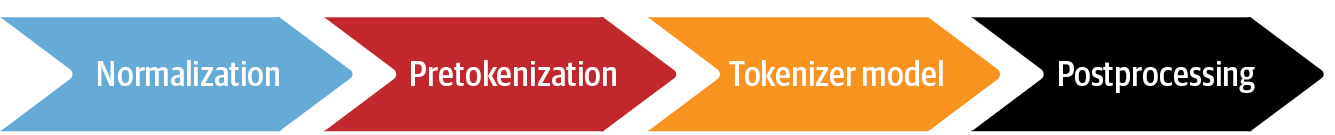

In [27]:
url_to_image('https://camo.githubusercontent.com/e24eb4651afde309f50348e6d9721698e3bbdb621462ce53f428e5e550148a29/68747470733a2f2f6769746875622e636f6d2f7269636b69657061726b2f6e6c702d776974682d7472616e73666f726d6572732f626c6f622f6d61696e2f696d616765732f6368617074657230345f746f6b656e697a65722d706970656c696e652e706e673f7261773d31')

- 정규화 : 원시 문자열을 더 깨끗하게 만들기 위해 적용하는 일련의 연산

- 사전 토큰화(pretokenization) : 텍스트를 더 작은 객체로 분할하며 훈련 마지막에 생성되는 토큰의 상한선을 제공
> - 사전 토큰화가 텍스트를 단어로 분할하고 최종 토큰은 이 단어의 일부가 됨
> - 한글에서 사전 토큰화를 하면 konlpy 사용, 추가로 형태소 분석 가능

- 토크나이저 모델(Tokenzier model) : 입력 텍스트 정규화와 사전 토큰화를 수행하고 난 후 토크나이저를 사용해 부분 단어 분할 모델을 단어에 적용
> 부분 단어 분할 모델 : BPE, Unigram, wordpiece 등
> 부분 단어 분할 모델을 사용해 vocab_size와 OOV token(unk)의 개수 감소

- 사후 처리(post processing) : 토큰화 파이프라인의 마지막 단계로, 토큰 리스트에 부가적 변환 적용
> ex) 입력 토큰 인덱스의 시퀀스 처음과 끝에 특수 토큰을 추가하는 경우

## SentencePiece Tokenizer

In [28]:
"".join(xlmr_tokens).replace(u"/u2581","")

'<s>▁Jack▁Sparrow▁loves▁New▁York▁!</s>'

- sentencePiece 토크나이저는 유니그램이라는 부분단어 분할 방식을 기반으로 각 입력 텍스트를 유니코드 문자 시퀀스로 인코딩

- Sentencepiece는 공백 문자가 유니코드 기호 U+2581 또는 아래 1/4 블록 문자라고 하는(_) 문자에 할당

- 다국어 말뭉치에 상당히 유용함

- bpe, wordpiece, sentencepiece를 정확히 이해해야 문제에 맞는 tokenizer 사용 가능

## 개체명 인식을 위한 트랜스포머

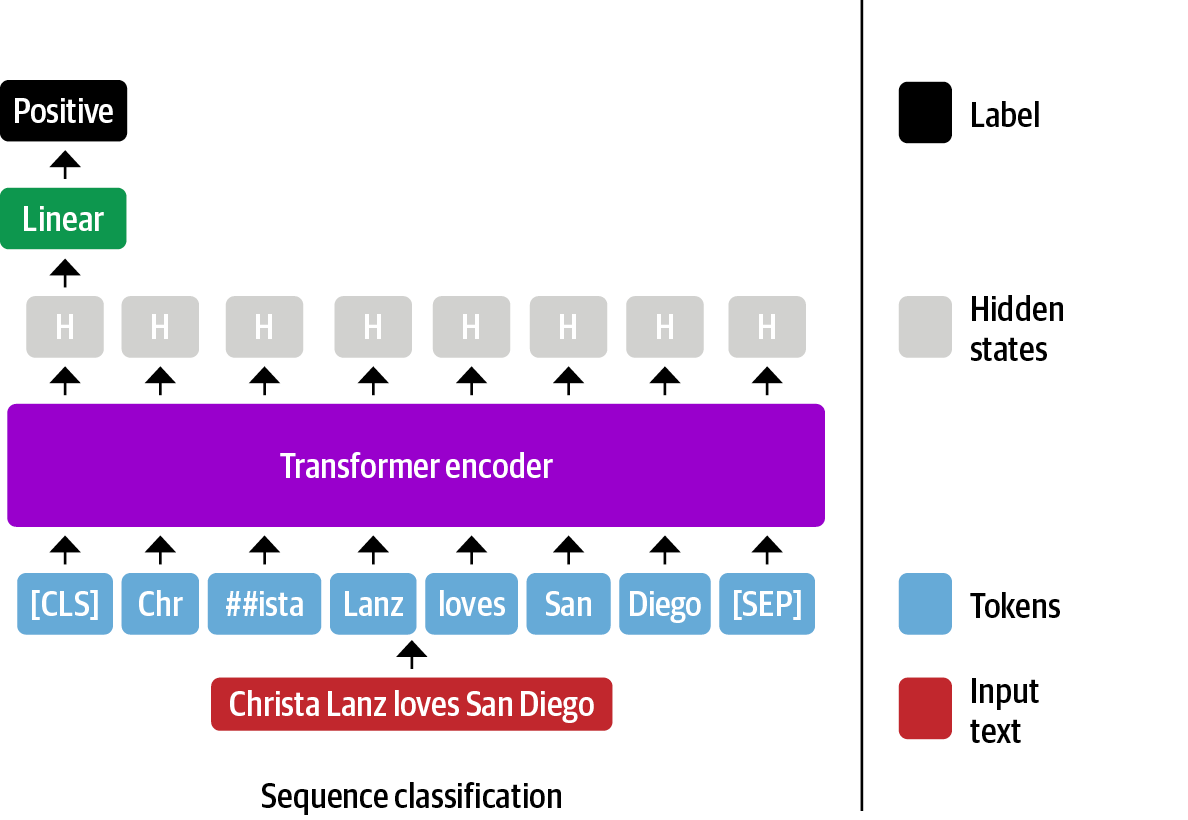

In [29]:
url_to_image('https://camo.githubusercontent.com/30a39dbbfe8adae1a44c3382b4b3e91cc0cae78a0d0c04616f87b173f5e485c9/68747470733a2f2f6769746875622e636f6d2f7269636b69657061726b2f6e6c702d776974682d7472616e73666f726d6572732f626c6f622f6d61696e2f696d616765732f6368617074657230345f636c662d6172636869746563747572652e706e673f7261773d31')

- text classification을 위해 BERT는 특수 토큰 CLS로 전체 텍스트 시퀀스를 표현

- 표현을 완전 연결 또는 밀집층에 통과시켜 이산적인 레이블 값을 출력

- NER을 종종 토큰 분류 작업으로 생각할 수도 있음

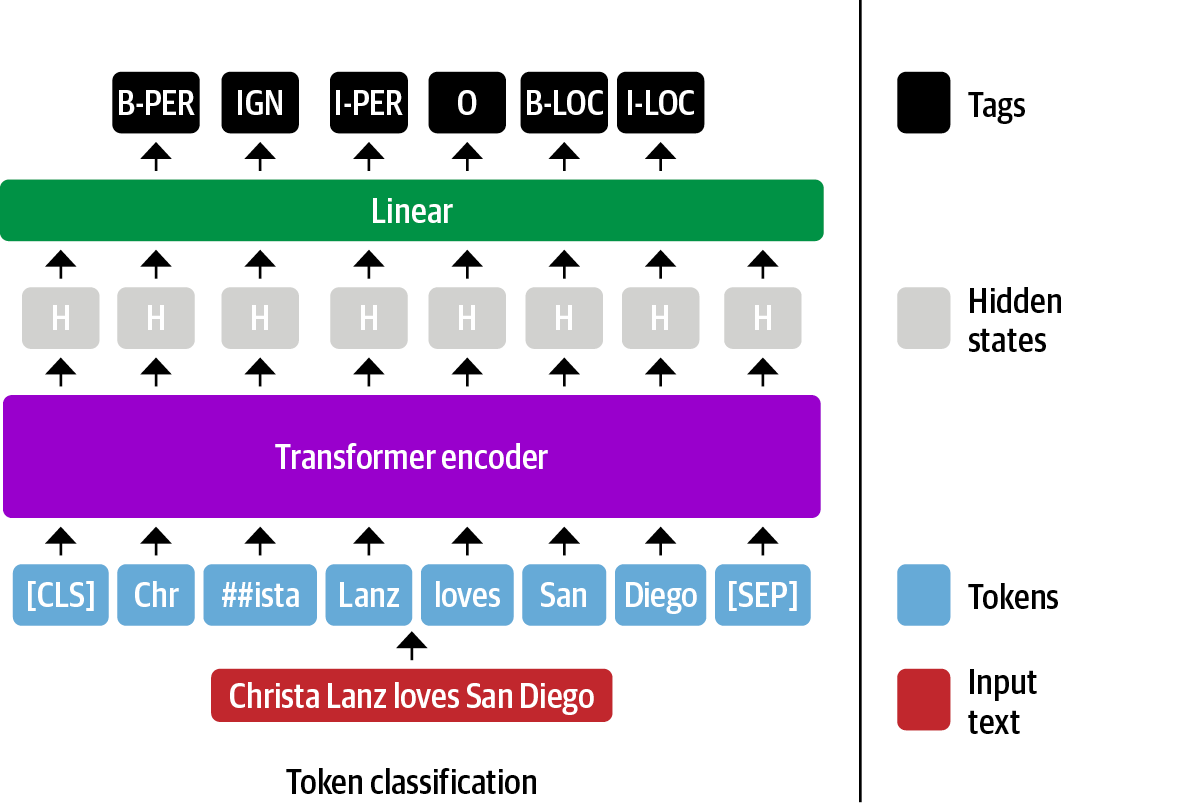

In [30]:
url_to_image('https://camo.githubusercontent.com/2ea90b56a1d1973c5e2a648685913e08e942b831e7079244ead14d17878bedff/68747470733a2f2f6769746875622e636f6d2f7269636b69657061726b2f6e6c702d776974682d7472616e73666f726d6572732f626c6f622f6d61696e2f696d616765732f6368617074657230345f6e65722d6172636869746563747572652e706e673f7261773d31')

# 트랜스포머 모델 클래스

### 바디와 헤드

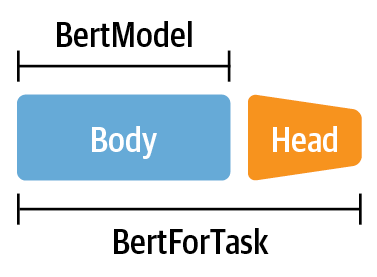

In [31]:
url_to_image('https://camo.githubusercontent.com/625401c544618ab4cc26ec864e9e6c5220da410dd9521d4ff0fc3f03003a7d54/68747470733a2f2f6769746875622e636f6d2f7269636b69657061726b2f6e6c702d776974682d7472616e73666f726d6572732f626c6f622f6d61696e2f696d616765732f6368617074657230345f626572742d626f64792d686561642e706e673f7261773d31')

- 트랜스포머는 바디와 헤드로 분리된 구조를 가지고 있으며, 이를 기반으로 기존 모델을 쉽게 확장 가능

## 토큰 분류를 위한 사용자 정의 모델 제작

In [32]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

In [33]:
class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        
        # 모델 바디 로드
        self.roberta = RobertaModel(config, add_pooling_layer = False)
        # add_pooling_layer = False로 CLS를 제외한 모든 은닉 상태가 반환되도록 함

        # 토큰 분류 헤드 준비
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # 가중치 로드 및 초기화
        self.init_weights()

    def forward(self, input_ids = None, attention_mask = None, token_type_ids = None,
                labels = None, **kwargs):
        # 모델 바디를 사용해 인코더 표현을 얻음
        outputs = self.roberta(input_ids, attention_mask = attention_mask,
                               token_type_ids = token_type_ids, **kwargs)
        # kwargs : (키워드 = 특정 값) 형태로 함수를 호출
        
        # encoder 표현을 head에 통과
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)

        # loss 계산
        loss = None
        if labels is not None :
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            # view : reshape와 유사, -1은 하나의 행으로 logits을 확장
        
        # 모델 출력 객체 반환
        return TokenClassifierOutput(loss = loss, logits = logits,
                                     hidden_states = outputs.hidden_states,
                                     attentions = outputs.attentions)


In [34]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [69]:
print(index2tag)
print(tag2index)

{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


In [35]:
from transformers import AutoConfig

xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels = tags.num_classes,
                                         id2label = index2tag, label2id = tag2index)

In [36]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = XLMRobertaForTokenClassification.from_pretrained(
    xlmr_model_name, config = xlmr_config
).to(device)

In [37]:
input_ids = xlmr_tokenizer.encode(text, return_tensors = "pt")

In [38]:
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index = ['Tokens', 'Input_ids'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,▁!,</s>
Input_ids,0,21763,37456,15555,5161,7,2356,5753,711,2


In [39]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim = -1)

In [40]:
outputs

tensor([[[ 0.1045,  0.3667, -0.8192, -0.0567, -0.3778,  0.4051, -0.2377],
         [ 0.0094,  0.2721, -0.8198,  0.0185, -0.2022,  0.3125,  0.0864],
         [ 0.0155,  0.3432, -0.8591,  0.0702, -0.1172,  0.4011, -0.0512],
         [-0.0068,  0.3437, -0.7982, -0.0022, -0.2002,  0.3560,  0.0760],
         [ 0.0309,  0.3128, -0.8690,  0.0626, -0.2600,  0.3343,  0.0494],
         [ 0.0277,  0.1897, -0.8978, -0.0728, -0.3035,  0.3701,  0.0643],
         [-0.0078,  0.2779, -0.9334, -0.1459, -0.2832,  0.3154,  0.0370],
         [ 0.0017,  0.2939, -0.9024, -0.0738, -0.2712,  0.2490,  0.0350],
         [ 0.0419,  0.3496, -0.8805,  0.0813, -0.3028,  0.3321, -0.0413],
         [ 0.1274,  0.3381, -0.8434, -0.0354, -0.3699,  0.4244, -0.2208]]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [41]:
predictions

tensor([[5, 5, 5, 5, 5, 5, 5, 1, 1, 5]], device='cuda:0')

In [42]:
print(f"시퀀스에 있는 토큰 개수 : {len(xlmr_tokens)}")
print(f"출력 크기 : {outputs.shape}")

시퀀스에 있는 토큰 개수 : 10
출력 크기 : torch.Size([1, 10, 7])


- 로짓의 크기는 [batch_size, num_tokens, num_tags]

In [43]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index = ['Tokens','Tags'])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,▁!,</s>
Tags,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-PER,B-PER,B-LOC


- 가중치를 랜덤으로 가졌다고 하지만, 전부 똑같은 결과가 나올수가 있는지 의문

In [44]:
def tag_text(text, tags, model, tokenizer):
    # 토큰 준비
    tokens = tokenizer(text).tokens()

    # 시퀀스를 ID로 인코딩
    input_ids = xlmr_tokenizer(text, return_tensors = "pt").input_ids.to(device)

    # 가능한 일곱 개의 클래스에 대한 분포 예측
    outputs = model(input_ids)[0]

    # 토큰마다 가장 가능성 있는 클래스를 argmax로 구현
    predictions = torch.argmax(outputs, dim = 2)
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index = ['Tokens', 'Tags'])

- torch.argmax
> - dim 파라미터를 추가하지 않은 경우 큰 숫자 순으로 tensor를 출력
> - dim = 0인 경우 열을 기준으로 max 값이 있는 index 출력 
> - dim = 1인 경우 행을 기준으로 max 값이 있는 index 출력
> - dim = -1인 경우 입력 텐서의 마지막 차원에서 최댓값 검색이 수행
>> - ex) 입력 텐서의 형태가 (batch_size, num_classes)일 경우, torch.argmax(input, dim=-1)는 num_classes 차원에서 각 행(즉, 배치의 각 샘플)의 최댓값의 인덱스를 반환
> - dim - 2인 경우 입력 텐서의 세 번째 차원에서 최댓값 검색을 수행
>> - ex) 입력 텐서의 형태가 (batch_size, sequence_length, num_classes)일 경우, torch.argmax(input, dim=2)는 배치의 각 샘플, num_classes 차원에서 각 시간 간격에서의 최댓값의 인덱스를 반환

## NER 작업을 위한 텍스트 토큰화

In [45]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [46]:
tokenized_input = xlmr_tokenizer(de_example['tokens'], is_split_into_words = True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids'])
pd.DataFrame([tokens], index = ["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [47]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index = ['Tokens', 'word_ids'])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
word_ids,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


- word_ids : 각 부분단어를 words 리스트에 있는 해당 단어의 인덱스에 매핑한 것

- 동일한 단어에서 나눠진 부분단어의 id는 동일, 특수토큰은 None

In [48]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids :
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previout_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "labels"]

pd.DataFrame([tokens, word_ids, label_ids,labels], index = index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,0,0,0,5,5,5,6,...,5,5,5,5,6,6,6,0,0,-100
labels,IGN,O,O,O,O,O,B-LOC,B-LOC,B-LOC,I-LOC,...,B-LOC,B-LOC,B-LOC,B-LOC,I-LOC,I-LOC,I-LOC,O,O,IGN


- nn.Crossentropyloss의 ignore_index 값이 -100 이기 때문에, 연속된 부분단어에 해당하는 토큰을 무시하기 위해 해당 인덱스를 사용

In [58]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, 
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [59]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True, 
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [60]:
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [62]:
panx_de_encoded['train']

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 12580
})

In [64]:
print(panx_de_encoded['train'][0])

{'input_ids': [0, 70101, 176581, 19, 142, 122, 2290, 708, 1505, 18363, 18, 23,
122, 127474, 15439, 13787, 14, 15263, 18917, 663, 6947, 19, 6, 5, 2],
'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1, 1, 1, 1], 'labels': [-100, 0, 0, -100, 0, 0, 5, -100, -100, 6, -100, 0, 0,
5, -100, 5, -100, -100, -100, 6, -100, -100, 0, -100, -100]}


## 성능 측정

In [65]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [70]:
import numpy as np

# 연속된 부분단어의 label id를 무시하는 함수 제작

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis = 2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # label_ids = -100 ignore
            if label_ids[batch_idx, seq_idx] != -100 :
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])
        
        labels_list.append(example_labels)
        preds_list.append(example_preds)
    
    return preds_list, labels_list


## XLM-Roberta fine-tuning

In [71]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 16
logging_steps = len(panx_de_encoded['train']) // batch_size

model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(
    output_dir = model_name, log_level = "error", num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    evaluation_strategy= "epoch",
    save_steps = 1e6, weight_decay = 0.01, disable_tqdm = False,
    logging_steps = logging_steps, push_to_hub = True
)

In [72]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [74]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [75]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

- batch에서 가장 큰 시퀀스 길이로 입력 시퀀스를 패딩하도록 data collator를 정의

- text classification과 달리 label도 sequence이기 때문에 label padding이 필수, 시퀀스를 -100으로 지정해 loss function이 무시하도록함

In [77]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config).to(device))

- Trainer를 위해 매번 새로운 모델을 만들지 않도록 함수 제작, train() 메서드 호출시 훈련되지 않은 모델을 로드

In [79]:
from transformers import Trainer

trainer = Trainer(model_init = model_init, args = training_args,
                  data_collator = data_collator, compute_metrics = compute_metrics,
                  train_dataset = panx_de_encoded['train'],
                  eval_dataset = panx_de_encoded['validation'],
                  tokenizer = xlmr_tokenizer)

Cloning https://huggingface.co/hr1588/xlm-roberta-base-finetuned-panx-de into local empty directory.


In [80]:
trainer.train()
trainer.push_to_hub(commit_message = "Training Completed !")

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.249500,0.176437,0.818388
2,0.129900,0.142740,0.856223
3,0.077100,0.140533,0.865468


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 32.0k/1.03G [00:00<?, ?B/s]

Upload file runs/Feb05_14-43-38_019102b4f598/1675608644.4788597/events.out.tfevents.1675608644.019102b4f598.14…

Upload file runs/Feb05_14-43-38_019102b4f598/events.out.tfevents.1675608644.019102b4f598.146.0: 100%|#########…

Upload file tokenizer.json:   0%|          | 32.0k/16.3M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.43k/3.43k [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   1%|          | 32.0k/4.83M [00:00<?, ?B/s]

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/hr1588/xlm-roberta-base-finetuned-panx-de
   40fe878..5555d60  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/hr1588/xlm-roberta-base-finetuned-panx-de
   40fe878..5555d60  main -> main

To https://huggingface.co/hr1588/xlm-roberta-base-finetuned-panx-de
   5555d60..99c3f1a  main -> main

   5555d60..99c3f1a  main -> main



'https://huggingface.co/hr1588/xlm-roberta-base-finetuned-panx-de/commit/5555d60bcca1b3841ee134210cb69951a9182e64'

In [81]:
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O
